In [1]:
import os
import csv
import json
import time
import datetime as dt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import ipywidgets as widgets
from dotenv import load_dotenv
from google.cloud import bigquery
import xgboost
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import math

sns.set_style("darkgrid")

In [2]:
# # For local running
# !gcloud auth login
!gcloud auth login --update-adc
!gcloud config set project stravasnooper-dev

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=IID0sjvsnY8TXB0XeZ90m4uVkfu6lM&access_type=offline&code_challenge=e9_ZepFwKO7yqgJA1XoEVAf9hPtIfzU02o_glCMXv94&code_challenge_method=S256


Application default credentials (ADC) were updated.

You are now logged in as [ty.elgin.andrews@gmail.com].
Your current project is [dev-nonprod-b66b].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].


In [3]:
GCP_PROJECT_ID = "stravasnooper-dev"
bqclient = bigquery.Client()

# Challenge Question: How can I increase the number of kudos I get on Strava?

I have been using Strava for 7+ years and while I'm not a slave to the kudos, I do get that hit of serretonin when my followers hit that kudos button on one of my rides.

Since I have all of my Strava data I thought I'd go about modelling how I might be able to maximize my kudos. Anecdotally, I've noticed particularly long acitvities garner more kudos. Activities in new locations, or acitvities with especially interesting names such as lyrics gain attention.

So first a couple challenges:

1. I don't know my total number of followers over the past 7 years only my current count, therefore more followers likely correlates with more kudos.

Hypotheses about how to get kudos:

1. Doing longer distance activities gets more kudos
2. Doing longer duration acitvities gets more kudos
3. Using unique names for activities gets more kudos vs. Stravas standard names
4. Doing activities less often gets you more kudos (but if they're longer likely better?)

## Data Access & Pre-Processing

A couple things need to get setup:

1. Need to estimate my no. of followers across time
2. Convert kudos into percent of total followers
3. Create a feature of unique activitiy name vs. not

In [4]:
def get_activity_data(bqclient, GCP_PROJECT_ID, start_date, end_date):

    activity_details_query = """
    DECLARE query_start_date DATE;
    DECLARE query_end_date DATE;
    SET query_start_date = DATE("{1}");
    SET query_end_date = DATE("{2}");

    SELECT
        *
    FROM `{0}.prod_dashboard.raw_strava_data`
    WHERE 
        DATE(start_date) >= query_start_date
        AND DATE(start_date) <= query_end_date
        AND type = "Ride"
        AND moving_time > 600 #min 10 min duration
    ORDER BY
        start_date DESC
    """.format(GCP_PROJECT_ID, str(start_date), str(end_date))

    try:
        strava_df = bqclient.query(activity_details_query).result().to_dataframe()
        print(f'get_activity_data: got {len(strava_df)} activities.')
        return strava_df
    except Exception as e:
        print(f"Issue with getting strava activities:\n {e}")
        return None

In [5]:
raw_strava_df = get_activity_data(bqclient, GCP_PROJECT_ID, start_date = dt.date(2000, 1,1), end_date=dt.date(2022,4,1))

get_activity_data: got 1387 activities.


In [6]:
# Load temp csv for offline prototyping
# raw_strava_df = pd.read_csv(os.path.join("..", "data", "raw", "raw_ride_data_log.csv"))

In [7]:
raw_strava_df.head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,external_id,upload_id,...,max_watts,weighted_average_watts,average_temp,distance_km,exer_start_time,act_type_perc_time,elapsed_time_hrs,moving_time_hrs,__index_level_0__,processed_timestamp
0,Lunch Ride,38963.1,5064,5454,412.0,Ride,NaN,6917143350,garmin_push_8564623453,7.360187e+09,...,NaN,NaN,9.0,38.9631,1900-01-01 12:37:05+00:00,0.219306,1.515000,1.406667,NaN,2022-04-04 19:00:12.857920
1,Afternoon Ride,36929.9,4714,5406,297.0,Ride,NaN,6882784120,garmin_push_8524700417,7.322776e+09,...,NaN,NaN,10.0,36.9299,1900-01-01 16:42:57+00:00,1.000000,1.501667,1.309444,NaN,2022-03-28 19:00:11.051440
2,Afternoon Ride,48488.0,10579,12354,1222.0,Ride,NaN,6856812475,6237b9b3bd52a72ee72a2aa9.fit,7.294770e+09,...,NaN,NaN,25.0,48.4880,1900-01-01 13:02:38+00:00,0.190857,3.431667,2.938611,NaN,2022-03-21 19:00:20.552496
3,Afternoon Ride,31361.0,6367,7535,595.0,Ride,NaN,6851148475,62368a938ec0c470749b2abe.fit,7.288596e+09,...,NaN,NaN,28.0,31.3610,1900-01-01 16:23:06+00:00,0.114868,2.093056,1.768611,NaN,2022-03-21 19:00:20.552496
4,Lunch Ride,53291.3,7606,7925,714.0,Ride,NaN,6850483511,garmin_push_8487822089,7.287866e+09,...,NaN,NaN,31.0,53.2913,1900-01-01 12:27:44+00:00,0.137221,2.201389,2.112778,NaN,2022-03-21 19:00:20.552496


In [8]:
raw_strava_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   name                    1387 non-null   object             
 1   distance                1387 non-null   float64            
 2   moving_time             1387 non-null   int64              
 3   elapsed_time            1387 non-null   int64              
 4   total_elevation_gain    1387 non-null   float64            
 5   type                    1387 non-null   object             
 6   workout_type            125 non-null    float64            
 7   id                      1387 non-null   int64              
 8   external_id             1381 non-null   object             
 9   upload_id               1381 non-null   float64            
 10  start_date              1387 non-null   datetime64[ns, UTC]
 11  start_date_local        1387 non-null   dat

In [6]:
def preprocess_strava_kudo_data(raw_df):

    processed_df = raw_df.copy(deep=True)

    processed_df.start_date = pd.to_datetime(processed_df.start_date)
    processed_df.start_date_local = pd.to_datetime(processed_df.start_date_local)

    processed_df["custom_name_bool"] = 1
    processed_df.loc[processed_df.name.isin(['Afternoon Ride', "Lunch Ride", 'Morning Ride', 'Evening Ride']), "custom_name_bool"] = 0

    processed_df["home_city_bool"] = 1
    processed_df.loc[processed_df.location_city.isin(["Victoria", "Calgary"]), "home_city_bool"] = 0

    #morning < 10:00 = 0, afternoon 10AM-4PM = 1, evening 16:00+ = 2
    processed_df["time_of_day_start"] = 0 # morning
    processed_df.loc[(processed_df.start_date_local.dt.hour > 10) & (processed_df.start_date_local.dt.hour < 16), "time_of_day_start"] = 1 #afternoon
    processed_df.loc[(processed_df.start_date_local.dt.hour >= 16), "time_of_day_start"] = 2 # evening

    return processed_df

In [7]:
proc_df = preprocess_strava_kudo_data(raw_strava_df)

# Estimating Follower Counts

TO get a since of kudos against how many people follow me a first attempt is to model it as a functino of time. A first attempt is doing a linear approximation starting with 0 followers and ending with how many I currently have.

First Activity: May 2013, 0 Followers
Current Date: Mar 2022, 139 Followers

$$y=mx+b=\frac{139}{106.06} + 0 = 1.3106x$$

Where:  
$x=$ No. of months since May 2013

In [8]:
begin_date = dt.date(2013, 5, 1)
end_date=dt.date(2022, 3, 1)

start_followers = 0
curr_followers = 139

days_per_month_avg = 365/12

months_since_joining = (end_date - begin_date).days/days_per_month_avg

slope = (curr_followers - start_followers)/months_since_joining

proc_df['months_since_join'] = 0

for i,x in proc_df.iterrows():
    
    proc_df.months_since_join.iloc[i] = ((x.start_date_local.year - begin_date.year)*12 - begin_date.month + x.start_date_local.month)

# predict follower count to nearest whole follower
proc_df['predicted_follower_count'] = round(proc_df.months_since_join*slope, 1)

proc_df["kudo_perc_of_followers"] = proc_df.kudos_count/proc_df.predicted_follower_count


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
proc_df.kudo_perc_of_followers.head()

0    0.057061
1    0.021598
2    0.021598
3    0.021598
4    0.014399
Name: kudo_perc_of_followers, dtype: float64

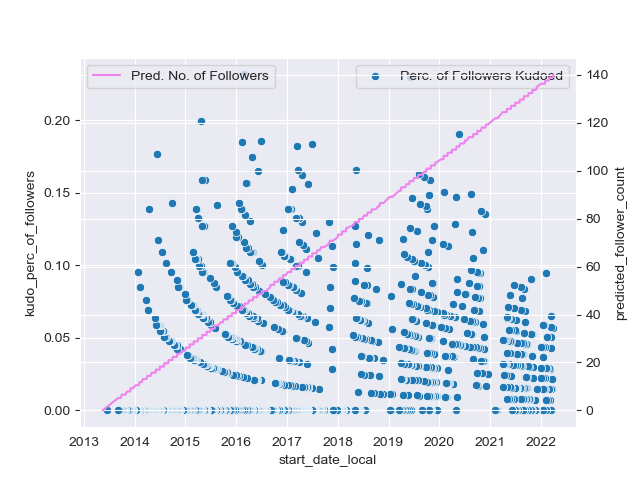

In [12]:
%matplotlib widget
fig, ax = plt.subplots()
sns.scatterplot(x='start_date_local', y='kudo_perc_of_followers', data=proc_df.loc[proc_df.distance/1000 < 220], label="Perc. of Followers Kudoed",ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='start_date_local', y="predicted_follower_count", data=proc_df, label="Pred. No. of Followers", ax=ax2, color='violet')
plt.show()

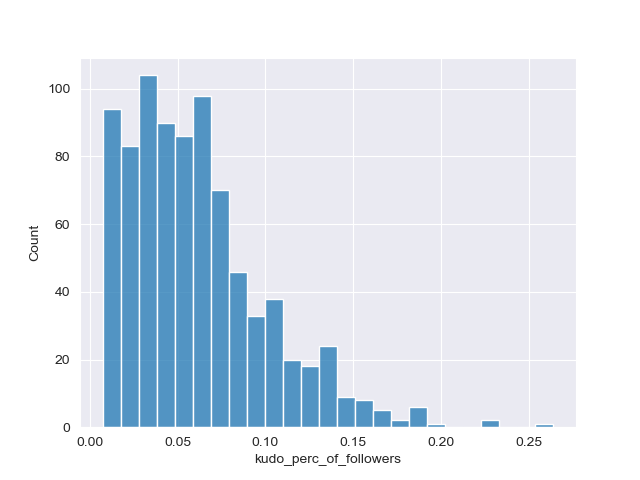

In [13]:
%matplotlib widget
fig, ax = plt.subplots()
sns.histplot(x="kudo_perc_of_followers", data=proc_df[proc_df.kudo_perc_of_followers > 0])
plt.show()

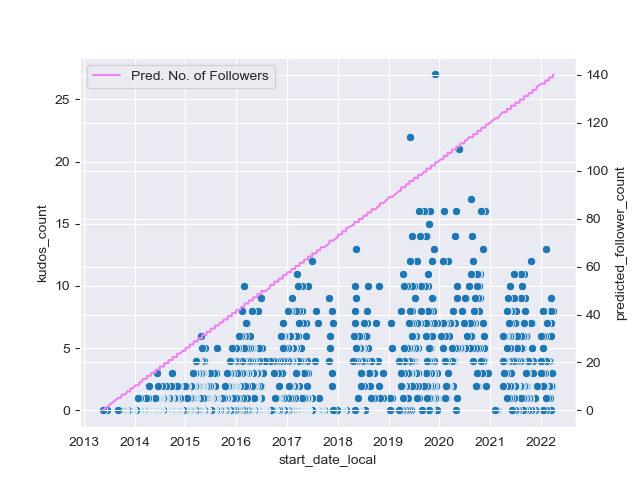

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(x="start_date_local", y="kudos_count", data=proc_df, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='start_date_local', y="predicted_follower_count", data=proc_df, label="Pred. No. of Followers", ax=ax2, color='violet')
plt.show()

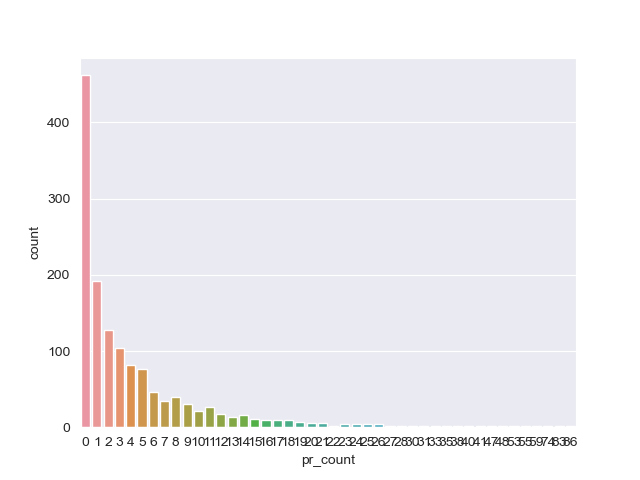

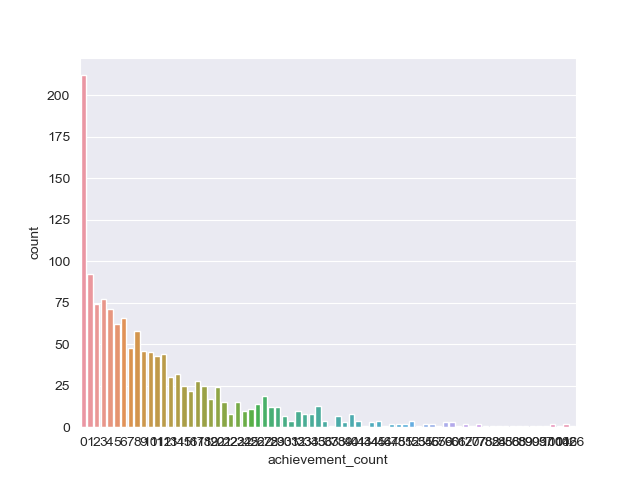

In [14]:
plt.subplots()
sns.countplot(x="pr_count", data=proc_df)
plt.show()

plt.subplots()
sns.countplot(x="achievement_count", data=proc_df)
plt.show()


# Predicting How Many Followers Give Kudos

Having a model that is able to accurately predict the number of kudos based off a number of features will be useful to maximize the number of kudos received per ride and we can observe what features have the greatest impact.

In [17]:
input_features = ["custom_name_bool", "distance_km", "moving_time_hrs", "total_photo_count", "pr_count", "athlete_count", "total_elevation_gain"]
predicted_feature = ["kudo_perc_of_followers"]
all_features = input_features + predicted_feature

model_df = proc_df[proc_df.kudo_perc_of_followers > 0][all_features].dropna()

X = model_df[input_features]
y = model_df[predicted_feature]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [21]:
reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_train)
r2 = reg.score(X_train, y_train)
rmse = math.sqrt(mean_squared_error(y_train, pred))

_ = evaluate(reg, X_train.to_numpy(), y_train.to_numpy())
_ = evaluate(reg, X_test.to_numpy(), y_test.to_numpy())

print(f'Linear Regression R^2: {r2:.3}')
print(f'Linear Regression RMSE: {rmse*100:.3}% of followers')

Model Performance
R^2 = 0.426
Average Error: 2.3228%.
RMSE = 3.047%
Model Performance
R^2 = 0.412
Average Error: 2.3172%.
RMSE = 2.958%
Linear Regression R^2: 0.426
Linear Regression RMSE: 3.05% of followers


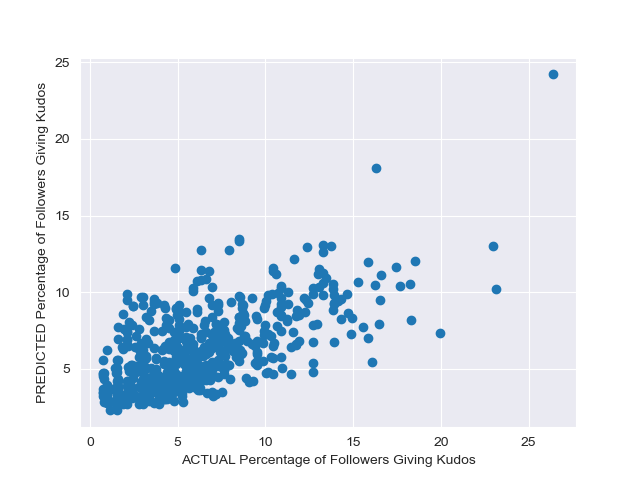

In [22]:
fig, ax = plt.subplots()
plt.scatter(y_train.to_numpy()*100, pred*100)
plt.xlabel("ACTUAL Percentage of Followers Giving Kudos")
plt.ylabel("PREDICTED Percentage of Followers Giving Kudos")
plt.show()

In [18]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)

    r2 = model.score(test_features, test_labels)
    rmse = math.sqrt(mean_squared_error(test_labels, predictions))
    accuracy = 100 - mape
    print('Model Performance')
    print(f'R^2 = {r2:.3f}')
    print(f'Average Error: {np.mean(errors)*100:.4f}%.')
    print(f'RMSE = {rmse*100:0.3f}%')
    
    return {'accuracy': accuracy, "R2": r2, "rmse":rmse, "avg_error":np.mean(errors)}

In [24]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [6, 7, 8],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [11, 12, 13],
    'n_estimators': [250, 300, 350]
}

# non-zero kudos optimal model
# param_grid = {'bootstrap': [True], 'max_depth': [6], 'max_features': [3], 'min_samples_leaf': [2], 'min_samples_split': [13], 'n_estimators': [350]}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\andrewt02\.conda\envs\stravasnooper\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [6, 7, 8],
                         'max_features': [3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [11, 12, 13],
                         'n_estimators': [250, 300, 350]},
             verbose=2)

In [25]:
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
pred = best_grid.predict(X_train)
_ = evaluate(best_grid, X_train.to_numpy(), y_train.to_numpy())
print("Test:")
_ = evaluate(best_grid, X_test.to_numpy(), y_test.to_numpy())

# rforest = RandomForestRegressor(max_depth=5, random_state=0)
# rforest.fit(X_train, y_train)

# acc = rforest.score(X_train, y_train)
# print(f'TRAIN: Random Forest Regression R^2: {acc*100:.3}%')
# acc = rforest.score(X_test, y_test)
# print(f'TEST: Random Forest Regression R^2: {acc*100:.3}%')

{'bootstrap': True, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 300}
Model Performance
R^2 = 0.614
Average Error: 3.7033%.
RMSE = 2.499%
Test:
Model Performance
R^2 = 0.392
Average Error: 3.5738%.
RMSE = 3.007%


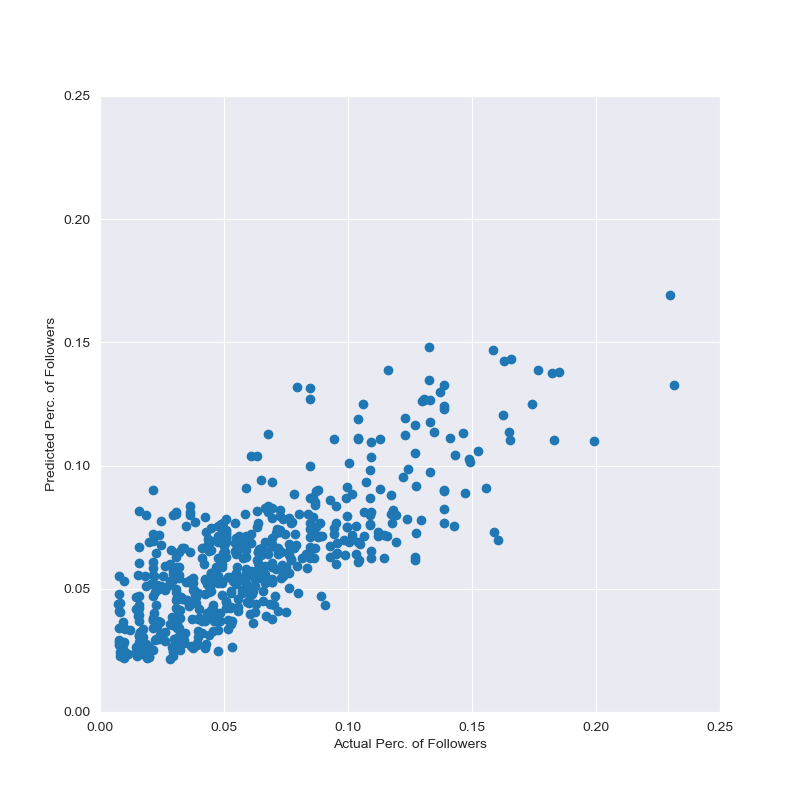

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(y_train.to_numpy(), best_grid.predict(X_train))
plt.ylim(0, 0.25)
plt.xlim(0,0.25)
plt.ylabel("Predicted Perc. of Followers")
plt.xlabel("Actual Perc. of Followers")
plt.show()

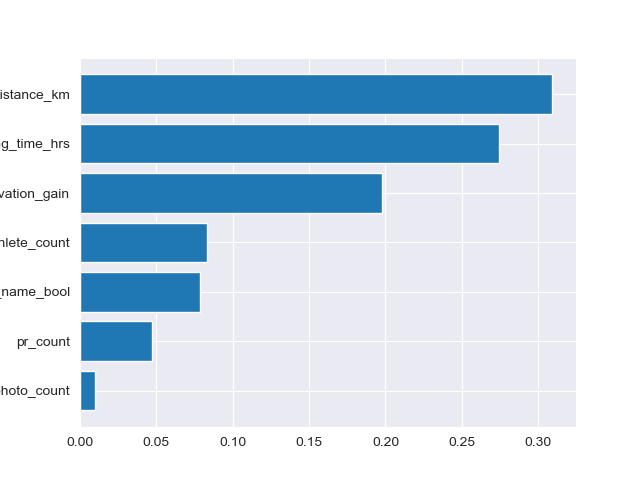

In [27]:
sorted_idx = best_grid.feature_importances_.argsort()

sorted_features = [input_features[i] for i in sorted_idx]
sorted_importance = [best_grid.feature_importances_[i] for i in sorted_idx]
plt.subplots()
plt.barh(sorted_features, sorted_importance)
plt.show()

In [29]:
explainer = shap.TreeExplainer(best_grid)

data_feat = X_test#[X_test.custom_name_bool == 0]

shap_values = explainer.shap_values(data_feat)

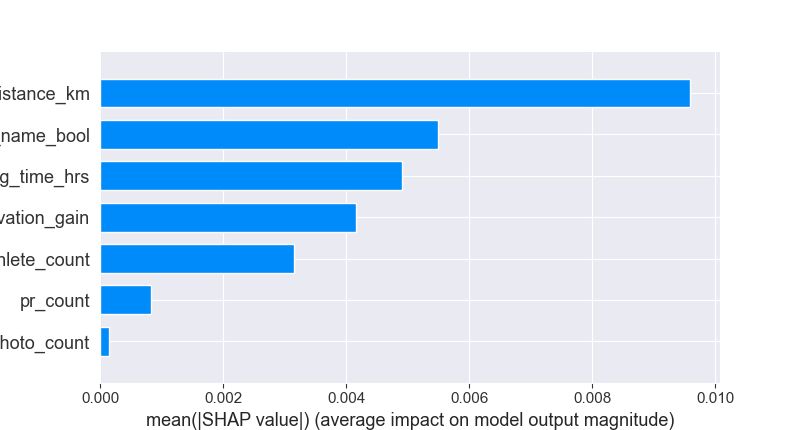

In [30]:
plt.subplots()
shap.summary_plot(shap_values, data_feat, plot_type="bar")
# plt.show()

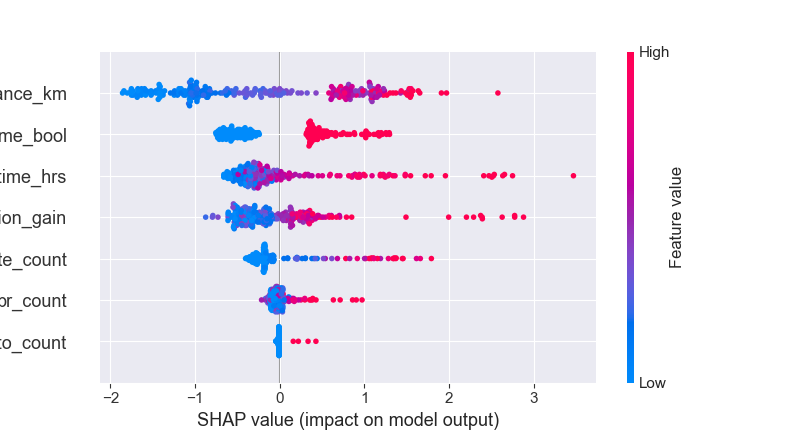

In [31]:
plt.subplots()
shap.summary_plot(shap_values*100, data_feat, plot_type="dot")

## XG Boost Model

In [33]:
# define model
# xgbm = xgboost.XGBRegressor(n_estimators=100, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgbm = xgboost.XGBRegressor(seed=20)

# non-zero kudos optimal xgbm
xgbm_params = { 'max_depth': [3,4,5],
           'learning_rate': [0.01,0.05],
           'n_estimators': [1000, 1200, 1400],
           'colsample_bytree': [0.4, 0.5,0.6]}

# Instantiate the grid search model
xgbm_grid_search = GridSearchCV(estimator = xgbm, param_grid = xgbm_params, 
                          cv = 4, n_jobs = -1, verbose = 2, scoring="neg_root_mean_squared_error")

# Fit the grid search to the data
xgbm_grid_search.fit(X_train, y_train)

print(xgbm_grid_search.best_params_)

xgbm_best_grid = xgbm_grid_search.best_estimator_

_ = evaluate(xgbm_best_grid, X_train.to_numpy(), y_train.to_numpy())

Fitting 4 folds for each of 54 candidates, totalling 216 fits
{'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Model Performance
R^2 = 0.658
Average Error: 3.7498%.
RMSE = 2.353%


In [34]:
xgbm_best_grid = xgbm_grid_search.best_estimator_

# pred = xgbm_best_grid.predict(X_train)

_ = evaluate(xgbm_best_grid, X_train.to_numpy(), y_train.to_numpy())
_ = evaluate(xgbm_best_grid, X_test.to_numpy(), y_test.to_numpy())

Model Performance
R^2 = 0.658
Average Error: 3.7498%.
RMSE = 2.353%
Model Performance
R^2 = 0.381
Average Error: 3.5822%.
RMSE = 3.034%


In [35]:
explainer = shap.TreeExplainer(xgbm_best_grid)

data_feat = X_train#[X_test.custom_name_bool == 0]

shap_values = explainer.shap_values(data_feat)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


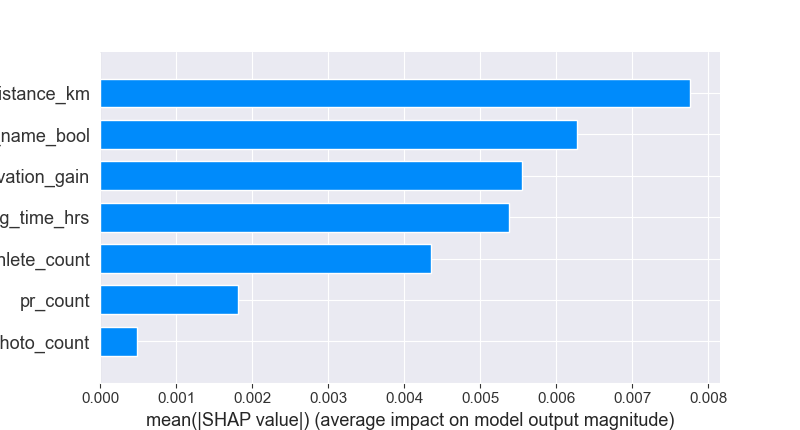

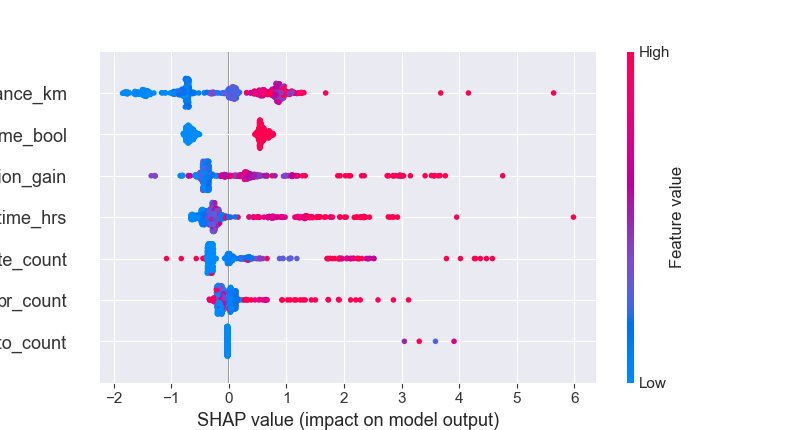

In [36]:
plt.subplots()
shap.summary_plot(shap_values, data_feat, plot_type="bar")

plt.subplots()
shap.summary_plot(shap_values*100, data_feat, plot_type="dot")

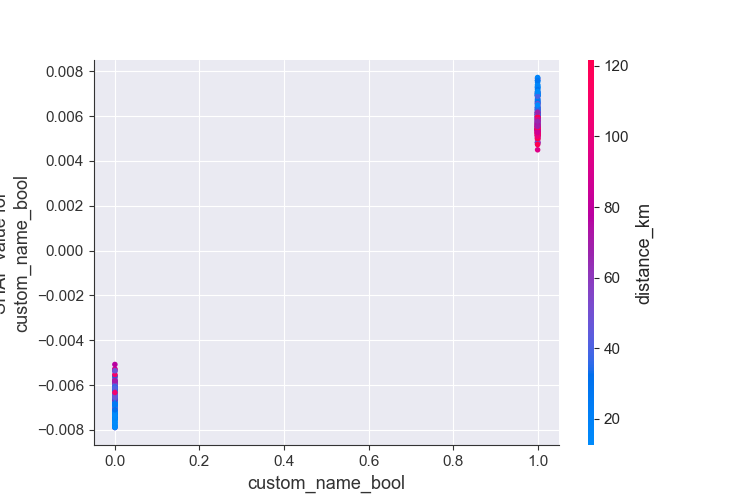

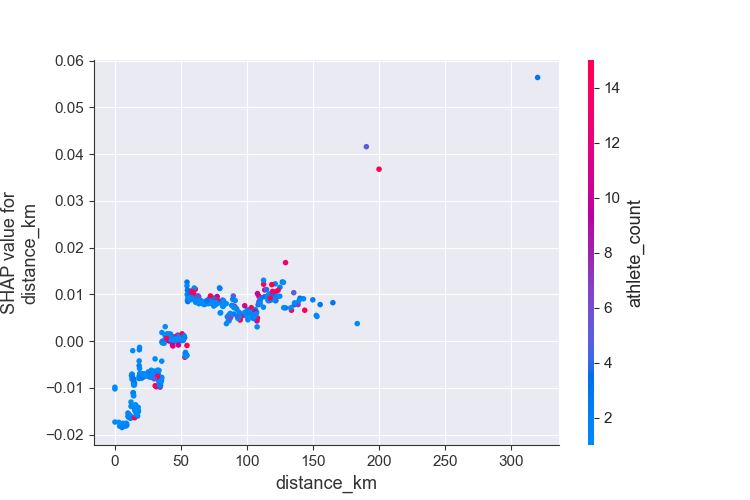

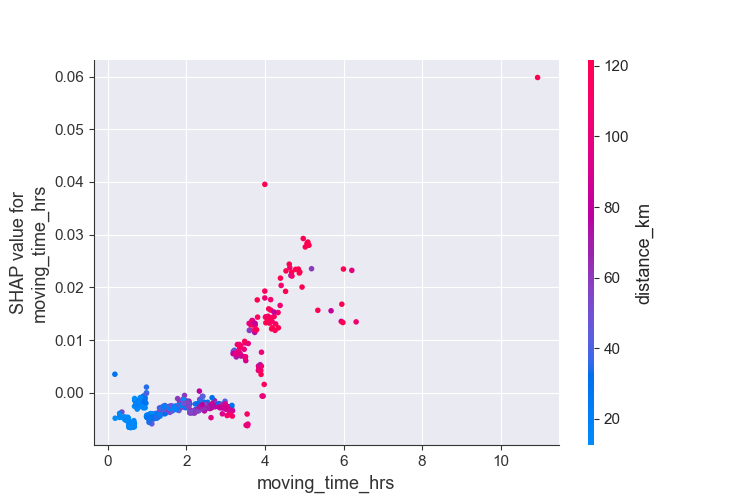

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


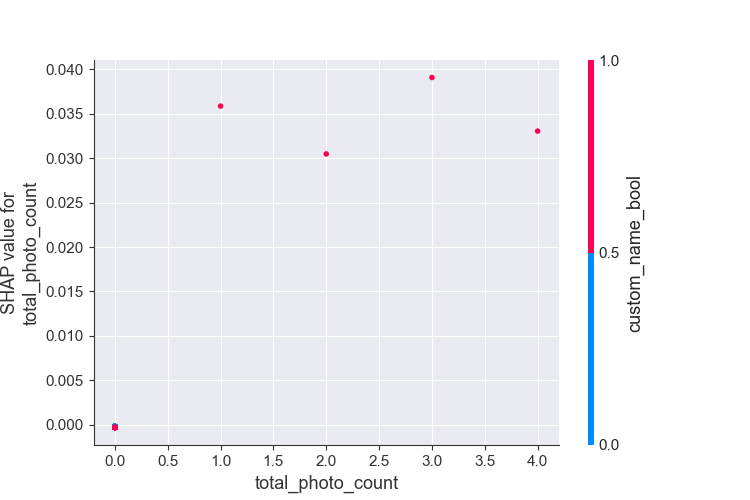

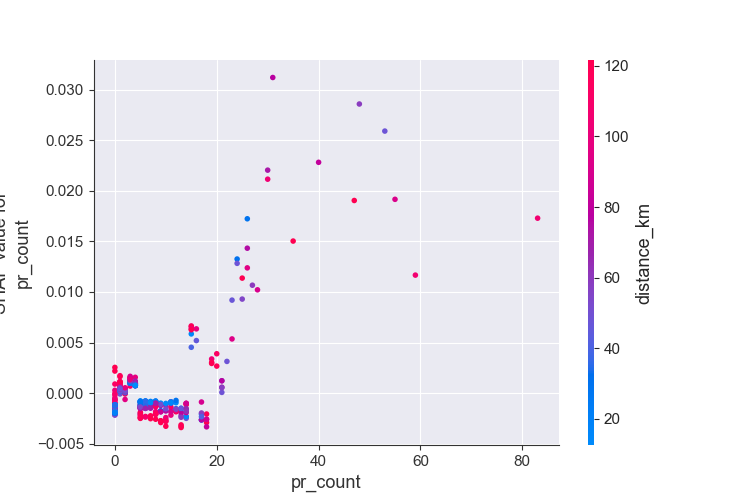

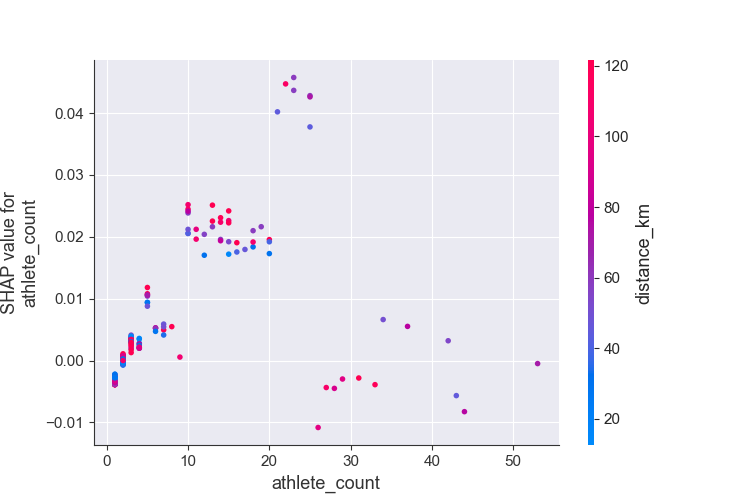

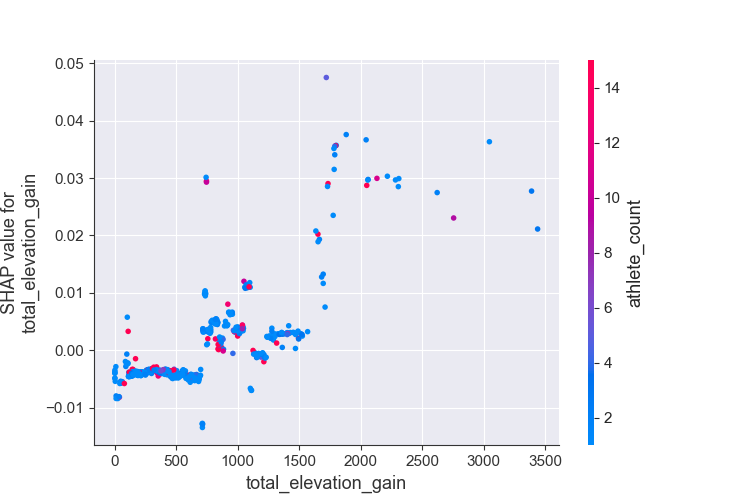

In [37]:
for name in X_train.columns:
    shap.dependence_plot(ind=name, shap_values=shap_values, features=X_train)

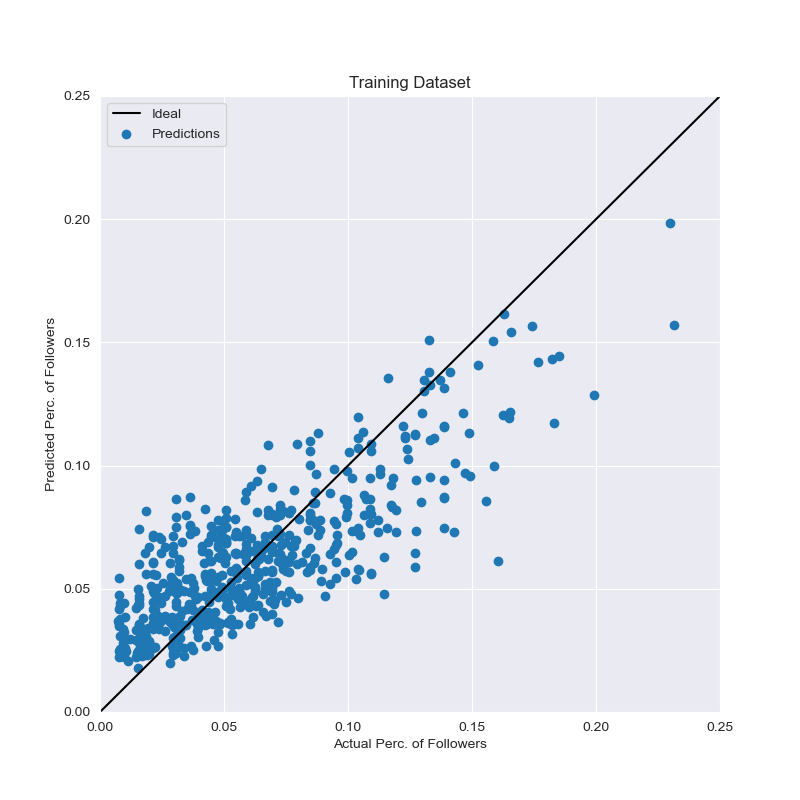

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(y_train, pd.Series(xgbm_best_grid.predict(X_train)), label="Predictions")
plt.plot([0, 0.25], [0,0.25], c="black", label="Ideal")
# plt.scatter(y_train.to_numpy(), best_grid.predict(X_train))
plt.title("Training Dataset")
plt.ylim(0, 0.25)
plt.xlim(0,0.25)
plt.ylabel("Predicted Perc. of Followers")
plt.xlabel("Actual Perc. of Followers")
plt.legend()
plt.show()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


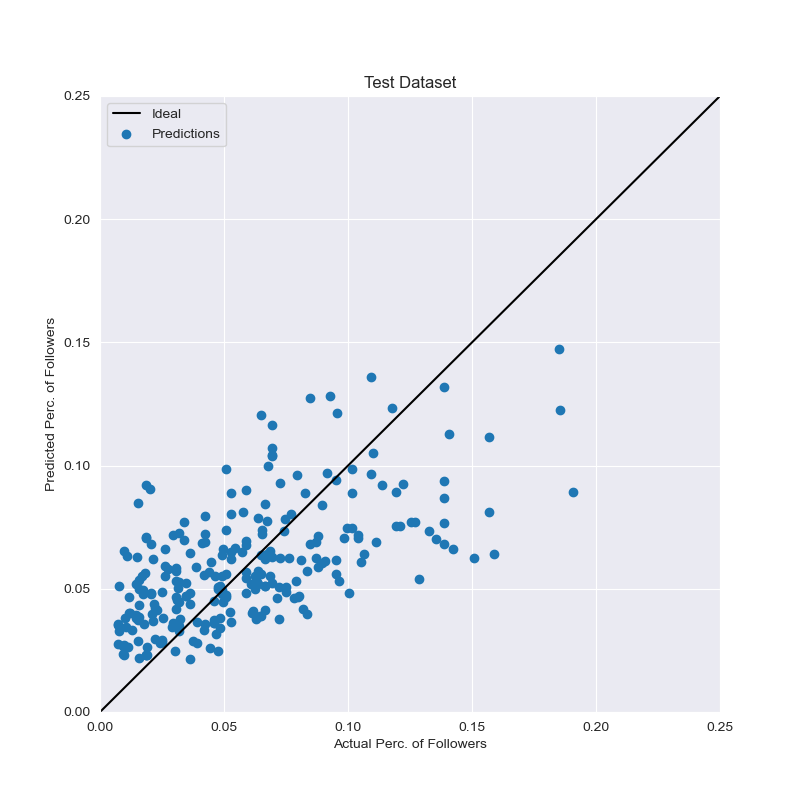

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(y_test, pd.Series(xgbm_best_grid.predict(X_test)), label="Predictions")
plt.plot([0, 0.25], [0,0.25], c="black", label="Ideal")
# plt.scatter(y_train.to_numpy(), best_grid.predict(X_train))
plt.ylim(0, 0.25)
plt.xlim(0,0.25)
plt.ylabel("Predicted Perc. of Followers")
plt.xlabel("Actual Perc. of Followers")
plt.legend()
plt.title("Test Dataset")
plt.show()

In [103]:
num_followers = 100
distance_km = 100
total_elevation_gain = 1500
moving_time_hrs = 2
athlete_count = 0
custom_name_bool = 0
pr_count = 0
total_photo_count = 0

sample = np.array([[custom_name_bool, distance_km, moving_time_hrs, total_photo_count, pr_count, athlete_count, total_elevation_gain]])

kudos = xgbm_best_grid.predict(sample)

print(np.round(kudos*num_followers, 0)[0])

5.0


# Initial Results

Using the 7 initial features, 

Linear Regression: 

Model Performance
R^2 = 0.426
Average Error: 2.3228%.
RMSE = 3.047%
Model Performance
R^2 = 0.412
Average Error: 2.3172%.
RMSE = 2.958%

Random Forest: Train
Model Performance
R^2 = 0.587
Average Error: 3.7017%.
RMSE = 2.584%
Test:
Model Performance
R^2 = 0.382
Average Error: 3.5884%.
RMSE = 3.034%

XGBoost:
Model Performance
R^2 = 0.638
Average Error: 3.7457%.
RMSE = 2.419%
Model Performance
R^2 = 0.456
Average Error: 3.5035%.
RMSE = 2.795%

|Model|Train RMSE (%)|Test RMSE (%)|Parameters|
|---|---|---|---|
|Linear Regression|3.05%| 2.96%|   |
|Random Forest|2.58%|3.03%|max depth:6, max features: 3, min samples per leaf: 5, min samples split: 13, n estimators: 300|
|XGBoost|2.42%|2.80%|colsample bytree: 0.4, learning rate: 0.01, max depth: 3, num estimators: 1000|

# Feature Engineering

Concepts to try:

- drop photo count, pr count
- include whether ride was modnring, mid day or evening
- include whether in "home city" or travelling elsewhere
- include acheivement count

In [15]:
# "home_city_bool", , "time_of_day_start"
input_features = ["custom_name_bool", "distance_km",  "achievement_count", "total_elevation_gain"] #"average_speed", "athlete_count",
predicted_feature = ["kudo_perc_of_followers"]
all_features = input_features + predicted_feature

model_df = proc_df[proc_df.kudo_perc_of_followers > 0][all_features].dropna()

X = model_df[input_features]
y = model_df[predicted_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [16]:
# define model
# xgbm = xgboost.XGBRegressor(n_estimators=100, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgbm = xgboost.XGBRegressor(seed=20)

# non-zero kudos optimal xgbm
xgbm_params = { 'max_depth': [3,4],
           'learning_rate': [0.01,0.05],
           'n_estimators': [800, 1000, 1500],
           'colsample_bytree': [0.3, 0.5, 0.7]}

# Instantiate the grid search model
xgbm_grid_search = GridSearchCV(estimator = xgbm, param_grid = xgbm_params, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring="neg_root_mean_squared_error")

# Fit the grid search to the data
xgbm_grid_search.fit(X_train, y_train)

print(xgbm_grid_search.best_params_)

xgbm_best_grid = xgbm_grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}


In [19]:
_ = evaluate(xgbm_best_grid, X_train.to_numpy(), y_train.to_numpy())
_ = evaluate(xgbm_best_grid, X_test.to_numpy(), y_test.to_numpy())

Model Performance
R^2 = 0.553
Average Error: 3.6808%.
RMSE = 2.688%
Model Performance
R^2 = 0.303
Average Error: 3.5275%.
RMSE = 3.221%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


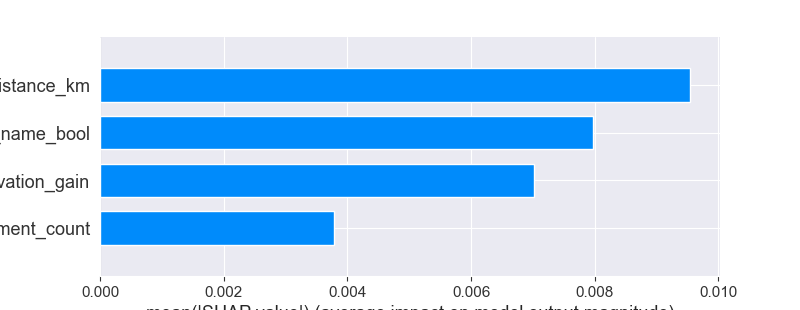

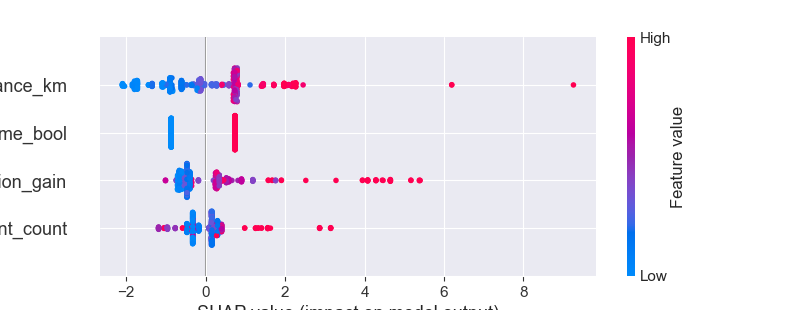

In [20]:
explainer = shap.TreeExplainer(xgbm_best_grid)

data_feat = X_train#[X_test.custom_name_bool == 0]

shap_values = explainer.shap_values(data_feat)

plt.subplots()
shap.summary_plot(shap_values, data_feat, plot_type="bar")

plt.subplots()
shap.summary_plot(shap_values*100, data_feat, plot_type="dot")

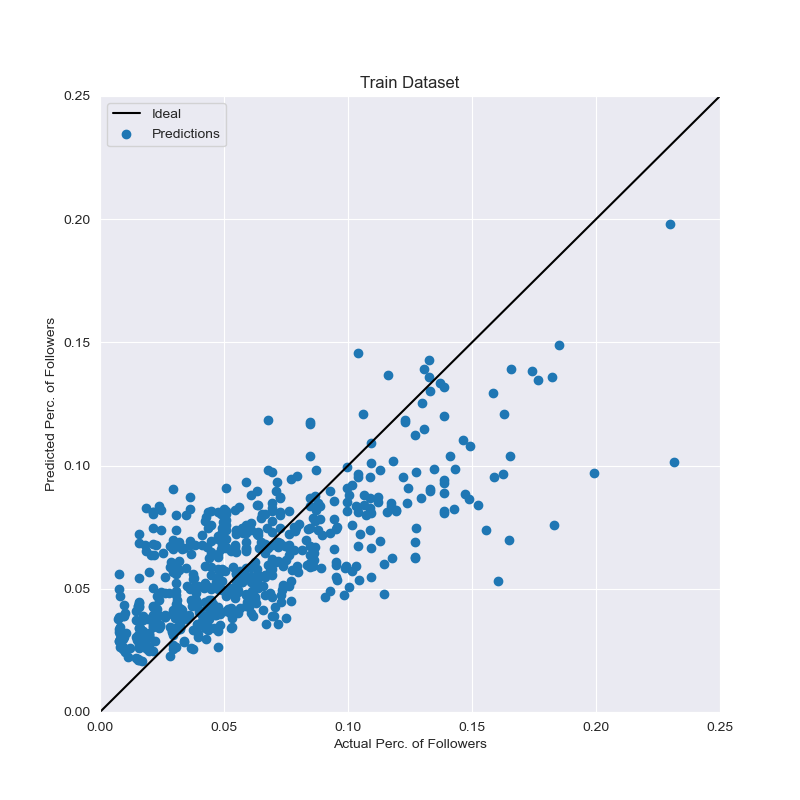

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(y_train, pd.Series(xgbm_best_grid.predict(X_train)), label="Predictions")
plt.plot([0, 0.25], [0,0.25], c="black", label="Ideal")
# plt.scatter(y_train.to_numpy(), best_grid.predict(X_train))
plt.ylim(0, 0.25)
plt.xlim(0,0.25)
plt.ylabel("Predicted Perc. of Followers")
plt.xlabel("Actual Perc. of Followers")
plt.legend()
plt.title("Train Dataset")
plt.show()

In [22]:
import ipywidgets as widgets
from ipywidgets import interactive, interact, interact_manual,fixed

In [29]:
num_followers = widgets.BoundedIntText(
    value=104,
    min=10,
    max=10000,
    step=1,
    description='No. of Followers:',
    disabled=False
)

distance = widgets.FloatSlider(
    value=50,
    min=min(dist_range),
    max=max(dist_range),
    step=dist_range[1] - dist_range[0],
    description='Distance (km)',
    # continuous_update=False,
    orientation='horizontal',
    # readout=True,
    readout_format='.0f',
    # layout={'width': 'max-content'}
)

# average_speed = widgets.FloatSlider(
#     value=30,
#     min=min(average_speed_range),
#     max=max(average_speed_range),
#     step=average_speed_range[1] - average_speed_range[0],
#     description='Avg. Speed (km/h):',
#     # continuous_update=False,
#     orientation='horizontal',
#     # readout=True,
#     readout_format='.1f',
#     # layout={'width': 'max-content'}
# )

elevation = widgets.FloatSlider(
    value=400,
    min=min(elevation_range),
    max=max(elevation_range),
    step=elevation_range[1] - elevation_range[0],
    description='Elevation (m)',
    # continuous_update=False,
    orientation='horizontal',
    # readout=True,
    readout_format='.0f',
    # layout={'width': 'max-content'}
)

achievement_count = widgets.FloatSlider(
    value=5,
    min=min(achievement_count_range),
    max=max(achievement_count_range),
    step=achievement_count_range[1] - achievement_count_range[0],
    description='Achievements on Ride',
    # continuous_update=False,
    orientation='horizontal',
    # readout=True,
    readout_format='.0f',
    # layout={'width': 'max-content'}
)

# athlete_count = widgets.FloatSlider(
#     value=0,
#     min=min(athletes_range),
#     max=max(athletes_range),
#     step=athletes_range[1] - athletes_range[0],
#     description='Other Riders',
#     # continuous_update=False,
#     orientation='horizontal',
#     # readout=True,
#     readout_format='.0f',
#     # layout={'width': 'max-content'}
# )

custom_name = widgets.RadioButtons(
    options = ["Standard Strava Title", "Custom Title"],
    value = "Standard Strava Title",
    description = "Custom Act. Name?", 
    orientation="horizontal", 
    # layout={'width': 'max-content'}
)

# selections = [num_followers, distance, average_speed, elevation, achievement_count,athlete_count, custom_name]

# widgets.VBox(selections)

In [30]:
num_followers = 100
distance_km = distance.value
total_elevation_gain = elevation.value
moving_time_hrs = moving_time.value
athletes = athlete_count.value
achievements = achievement_count.value

if custom_name.value == "Custom Title": 
    custom_name_bool = 1 
else:
    custom_name_bool = 0
    
pr_count = 0
total_photo_count = 0

sample = np.array([[custom_name_bool, distance_km, moving_time_hrs, achievements,  athletes, total_elevation_gain]])

kudos = xgbm_best_grid.predict(sample)

print(np.round(kudos*num_followers, 0)[0])

NameError: name 'moving_time' is not defined

In [31]:
def f(distance, elevation, achievement_count, custom_name, num_followers):

    print(distance, elevation, achievement_count, custom_name,num_followers)

    # num_followers = 100

    if custom_name == "Custom Title": 
        custom_name_bool = 1 
    else:
        custom_name_bool = 0

    sample = np.array([[custom_name_bool, distance,  achievement_count,  elevation]])

    kudos = xgbm_best_grid.predict(sample)*num_followers

    fig, ax = plt.subplots(2,2,figsize=(12,8), sharey=False)
    # plt.scatter(X_train.distance_km, y_train, label="Training Data")
    
    ax[0,0].plot(raw_df.loc[(raw_df.custom_name_bool == custom_name_bool) & (raw_df.achievements == achievement_count) &
                            (raw_df.elevation == elevation),'distance'], 
                raw_df.loc[(raw_df.custom_name_bool == custom_name_bool) & (raw_df.achievements == achievement_count) &
                            (raw_df.elevation == elevation), 'kudos_prediction']*num_followers, 
                label="Model Fit", c='red', zorder=1)
    ax[0,0].title.set_text("Ride Distance")
    ax[0,0].scatter(distance, kudos, c="green", label="Current Prediction", zorder=2)

    ax[0,1].bar(raw_df.loc[(raw_df.distance == distance) & (raw_df.achievements == achievement_count) &
                            (raw_df.elevation == elevation),'custom_name_bool'], 
                raw_df.loc[(raw_df.distance == distance) & (raw_df.achievements == achievement_count) &
                            (raw_df.elevation == elevation), 'kudos_prediction']*num_followers, 
                label="Model Fit", color='red', tick_label=["Standard Ride Name", "Custom Ride Name"], zorder=1)
    ax[0,1].scatter(custom_name_bool, kudos, c="green", label="Current Prediction", zorder=2)
    ax[0,1].title.set_text("Custom Ride Name")

    
    ax[1,0].plot(raw_df.loc[(raw_df.distance == distance) & (raw_df.achievements == achievement_count) &
                             (raw_df.custom_name_bool == custom_name_bool) ,'elevation'], 
                raw_df.loc[(raw_df.distance == distance) & (raw_df.achievements == achievement_count) &
                            (raw_df.custom_name_bool == custom_name_bool), 'kudos_prediction']*num_followers, 
                label="Model Fit", c='red', zorder=1)
    ax[1,0].title.set_text("Elevation Gain")
    ax[1,0].scatter(elevation, kudos, c="green", label="Current Prediction", zorder=2)

    ax[1,1].plot(raw_df.loc[(raw_df.distance == distance) & (raw_df.elevation == elevation) &
                            (raw_df.custom_name_bool == custom_name_bool) ,'achievements'], 
                raw_df.loc[(raw_df.distance == distance) & (raw_df.elevation == elevation) &
                            (raw_df.custom_name_bool == custom_name_bool), 'kudos_prediction']*num_followers, 
                label="Model Fit", c='red', zorder=1)
    ax[1,1].title.set_text("No. of Achievements")
    ax[1,1].scatter(achievement_count, kudos, c="green", label="Current Prediction", zorder=2)

    # ax[0,0].plot([0,1,2], [2,4,8], label="Model Fit", c='red')
    # plt.scatter(distance, kudos*num_followers, label="Current Selection", c='green')
    # plt.plot([0, 0.25], [0,0.25], c="black", label="Ideal")
    # plt.scatter(y_train.to_numpy(), best_grid.predict(X_train))

    # Setting the values for all axes.
    plt.setp(ax, ylim=(raw_df.kudos_prediction.min()*num_followers - 1, raw_df.kudos_prediction.max()*num_followers + 1))
    # plt.xlim(0,0.25)
    # plt.ylabel("No. of Kudos")
    # plt.xlabel("Distance")
    # plt.legend()
    plt.suptitle(f'Prediction: {round(kudos[0]):.0f} Kudos out of {round(raw_df.kudos_prediction.max()*num_followers):.0f} Max Possible Kudos')
    plt.show()

interactive_plot = interact_manual(f,  
                            distance=distance,  
                            elevation=elevation, 
                            achievement_count=achievement_count, 
                            custom_name=custom_name,
                            num_followers=num_followers) 
# output = interactive_plot.children[-1]
# output.layout.height = '900px'
interactive_plot

interactive(children=(FloatSlider(value=50.0, description='Distance (km)', max=220.0, min=20.0, readout_format…

<function __main__.f(distance, elevation, achievement_count, custom_name, num_followers)>

# Saving Generated Data/Model for Re-Use

In [ ]:
def generate_ride_dataset_ranges(dist_range, elevation_range, achievement_count_range, custom_name_range):

    raw_list = list([])
    for dist in dist_range:

        for elev in elevation_range:

            for achiev in achievement_count_range:

                for name in custom_name_range:

                    raw_list.append([name, dist, achiev, elev])
    
    return np.array(raw_list)


In [ ]:
dist_range = np.arange(20, 230, 10)
elevation_range = np.arange(100, 3000, 100)
achievement_count_range = np.arange(0,50, 5)
custom_name_range = np.array([0,1])

raw_data = generate_ride_dataset_ranges(dist_range, elevation_range, achievement_count_range, custom_name_range)

raw_df = pd.DataFrame(data=raw_data, columns=['custom_name_bool', 'distance', 'achievements', "elevation"])

raw_df["kudos_prediction"] = xgbm_best_grid.predict(raw_data)

In [125]:
output_file = os.path.join(os.getcwd(), "..", "data", "processed", "kudos_prediction", f"kudos_model_raw_data_{str(dt.date.today())}.csv")

output_model = os.path.join(os.getcwd(), "..", "models", "kudos_prediction", f"kudos_prediction_xgbm_model_{str(dt.date.today())}.pkl")

In [109]:
raw_df.to_csv(output_file)

In [127]:
import pickle

metrics = evaluate(xgbm_best_grid, X_train.to_numpy(), y_train.to_numpy())

model_tuple = (xgbm_best_grid, input_features, predicted_feature, metrics)

with open(output_model, 'wb') as file:

    pickle.dump(model_tuple, file)

Model Performance
R^2 = 0.553
Average Error: 3.6808%.
RMSE = 2.688%


# Plotly Dash Plots Protos